In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [2]:
!pip install -q transformers

In [3]:
import seaborn as sns

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle


import plotly.express as px
import plotly.graph_objects as go

import os
import re
import json
import copy
import collections

In [4]:
data = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",
                   encoding='latin-1')
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
data = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",
                   encoding='latin-1')
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [7]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "TweetText"]
data.columns = DATASET_COLUMNS
data.head()

,target,ids,date,flag,user,TweetText
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
data.drop(['ids','date','flag','user'],axis = 1,inplace = True)

In [10]:
data.head()

,target,TweetText
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [11]:
num_samples = 20000

In [12]:
# Sample the specified number of samples from each class
positive_data = data[data.target == 4].sample(n=num_samples, random_state=42)
negative_data = data[data.target == 0].sample(n=num_samples, random_state=42)

# Combine the sampled data
balanced_data = pd.concat([positive_data, negative_data])

# Print the shapes of the sampled data
print(positive_data.shape)
print(negative_data.shape)
print(balanced_data.shape)

(20000, 2)
(20000, 2)
(40000, 2)


In [13]:
balanced_data['Clean_TweetText'] = balanced_data['TweetText'].str.replace("@", "") 
balanced_data.head()

,target,TweetText,Clean_TweetText
1012187,4,Is lookin 4ward to a long weekend really dont...,Is lookin 4ward to a long weekend really dont...
1099035,4,#myweakness Is music and i live to meet the p...,#myweakness Is music and i live to meet the p...
1275977,4,figured out the Internet on my new iPod,figured out the Internet on my new iPod
1388987,4,@hillsongunited can't wait to worship with you...,hillsongunited can't wait to worship with you ...
938858,4,@sillybeggar Congrats James !! I'm sure the bo...,sillybeggar Congrats James !! I'm sure the boo...


In [14]:
balanced_data['Clean_TweetText'] = balanced_data['Clean_TweetText'].str.replace(r"http\S+", "") 
balanced_data.head()

,target,TweetText,Clean_TweetText
1012187,4,Is lookin 4ward to a long weekend really dont...,Is lookin 4ward to a long weekend really dont...
1099035,4,#myweakness Is music and i live to meet the p...,#myweakness Is music and i live to meet the p...
1275977,4,figured out the Internet on my new iPod,figured out the Internet on my new iPod
1388987,4,@hillsongunited can't wait to worship with you...,hillsongunited can't wait to worship with you ...
938858,4,@sillybeggar Congrats James !! I'm sure the bo...,sillybeggar Congrats James !! I'm sure the boo...


In [15]:
balanced_data['Clean_TweetText'] = balanced_data['Clean_TweetText'].str.replace("[^a-zA-Z]", " ") 
balanced_data.head()

,target,TweetText,Clean_TweetText
1012187,4,Is lookin 4ward to a long weekend really dont...,Is lookin 4ward to a long weekend really dont...
1099035,4,#myweakness Is music and i live to meet the p...,#myweakness Is music and i live to meet the p...
1275977,4,figured out the Internet on my new iPod,figured out the Internet on my new iPod
1388987,4,@hillsongunited can't wait to worship with you...,hillsongunited can't wait to worship with you ...
938858,4,@sillybeggar Congrats James !! I'm sure the bo...,sillybeggar Congrats James !! I'm sure the boo...


In [17]:
import nltk

In [18]:
stopwords=nltk.corpus.stopwords.words('english')

In [19]:
def remove_stopwords(text):
    clean_text=' '.join([word for word in text.split() if word not in stopwords])
    return clean_text

In [20]:
balanced_data['Clean_TweetText'] = balanced_data['Clean_TweetText'].apply(lambda text : remove_stopwords(text.lower()))
balanced_data.head()

,target,TweetText,Clean_TweetText
1012187,4,Is lookin 4ward to a long weekend really dont...,lookin 4ward long weekend really dont want go ...
1099035,4,#myweakness Is music and i live to meet the p...,#myweakness music live meet people make
1275977,4,figured out the Internet on my new iPod,figured internet new ipod
1388987,4,@hillsongunited can't wait to worship with you...,hillsongunited can't wait worship guys tonight...
938858,4,@sillybeggar Congrats James !! I'm sure the bo...,sillybeggar congrats james !! i'm sure book go...


In [21]:
balanced_data['Clean_TweetText'] = balanced_data['Clean_TweetText'].apply(lambda x: x.split())
balanced_data.head()

,target,TweetText,Clean_TweetText
1012187,4,Is lookin 4ward to a long weekend really dont...,"[lookin, 4ward, long, weekend, really, dont, w..."
1099035,4,#myweakness Is music and i live to meet the p...,"[#myweakness, music, live, meet, people, make]"
1275977,4,figured out the Internet on my new iPod,"[figured, internet, new, ipod]"
1388987,4,@hillsongunited can't wait to worship with you...,"[hillsongunited, can't, wait, worship, guys, t..."
938858,4,@sillybeggar Congrats James !! I'm sure the bo...,"[sillybeggar, congrats, james, !!, i'm, sure, ..."


In [22]:
from nltk.stem.porter import * 

stemmer = PorterStemmer()

balanced_data['Clean_TweetText'] = balanced_data['Clean_TweetText'].apply(lambda x: [stemmer.stem(i) for i in x])
balanced_data.head()

,target,TweetText,Clean_TweetText
1012187,4,Is lookin 4ward to a long weekend really dont...,"[lookin, 4ward, long, weekend, realli, dont, w..."
1099035,4,#myweakness Is music and i live to meet the p...,"[#myweak, music, live, meet, peopl, make]"
1275977,4,figured out the Internet on my new iPod,"[figur, internet, new, ipod]"
1388987,4,@hillsongunited can't wait to worship with you...,"[hillsongunit, can't, wait, worship, guy, toni..."
938858,4,@sillybeggar Congrats James !! I'm sure the bo...,"[sillybeggar, congrat, jame, !!, i'm, sure, bo..."


In [23]:
balanced_data['Clean_TweetText'] = balanced_data['Clean_TweetText'].apply(lambda x: ' '.join([w for w in x]))
balanced_data.head()

,target,TweetText,Clean_TweetText
1012187,4,Is lookin 4ward to a long weekend really dont...,lookin 4ward long weekend realli dont want go ...
1099035,4,#myweakness Is music and i live to meet the p...,#myweak music live meet peopl make
1275977,4,figured out the Internet on my new iPod,figur internet new ipod
1388987,4,@hillsongunited can't wait to worship with you...,hillsongunit can't wait worship guy tonight. i...
938858,4,@sillybeggar Congrats James !! I'm sure the bo...,sillybeggar congrat jame !! i'm sure book go h...


In [24]:
balanced_data['Clean_TweetText'] = balanced_data['Clean_TweetText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
balanced_data.head()

,target,TweetText,Clean_TweetText
1012187,4,Is lookin 4ward to a long weekend really dont...,lookin 4ward long weekend realli dont want wor...
1099035,4,#myweakness Is music and i live to meet the p...,#myweak music live meet peopl make
1275977,4,figured out the Internet on my new iPod,figur internet ipod
1388987,4,@hillsongunited can't wait to worship with you...,hillsongunit can't wait worship tonight. it'll...
938858,4,@sillybeggar Congrats James !! I'm sure the bo...,sillybeggar congrat jame sure book huge success


In [25]:
balanced_data.to_csv("Sentiment_140_Clean_for_LLM.csv")

In [26]:
from sklearn.model_selection import train_test_split

train_valid_data, test_data = train_test_split(balanced_data, train_size=0.8, shuffle=True, random_state=42,
                                               stratify=balanced_data['target'])

train_data, valid_data = train_test_split(train_valid_data, train_size=0.8, shuffle=True, random_state=42,
                                          stratify=train_valid_data['target'])

In [27]:
print('{:>5,} Training samples'.format(len(train_data)))
print('{:>5,} Test samples'.format(len(test_data)))
print('{:>5,} Validation samples'.format(len(valid_data)))

25,600 Training samples
8,000 Test samples
6,400 Validation samples


In [29]:
train_data.head()

,target,TweetText,Clean_TweetText
1132096,4,@rainbowPatrick im so relieved you liked my le...,rainbowpatrick reliev like letter glad year go...
1596848,4,@beneubanks Dont forget to include the heat an...,beneubank dont forget includ heat humid #shrm09
1322928,4,Oasis video on MTV2. It's the little things,oasi video mtv2. littl thing
368856,0,On my way to the train an older woman had fall...,train older woman fallen stairs. blood liter b...
1161293,4,had a good night,good night


In [30]:
train_data['target'] = train_data['target'].replace(4, 1)
valid_data['target'] = valid_data['target'].replace(4, 1)
test_data['target'] = test_data['target'].replace(4, 1)

In [31]:
train = train_data.reset_index(drop=True)
valid = valid_data.reset_index(drop=True)
test = test_data.reset_index(drop=True)

x_train, y_train = train['Clean_TweetText'].values.tolist(), train['target'].values.tolist()
x_valid, y_valid = valid['Clean_TweetText'].values.tolist(), valid['target'].values.tolist()
x_test, y_test = test['Clean_TweetText'].values.tolist(), test['target'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

(25600, 3)
(6400, 3)
(8000, 3)


In [45]:
pip install wandb==0.16.6

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.4 MB/s eta 0:00:0000:010:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.17.7
    Uninstalling wandb-0.17.7:
      Successfully uninstalled wandb-0.17.7
Note: you may need to restart the kernel to use updated packages.


In [70]:
!wandb offline
!wandb disabled

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


W&B disabled.


In [33]:
!pip install datasets
!pip install transformers

In [34]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import os.path
from os import path
from datasets import Dataset
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset, DatasetDict

In [35]:
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased",
                                                           num_labels=2, 
                                                           ignore_mismatched_sizes=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [ ]:
wandb.init(project="Aylin-NZ-Final-Thesis")

In [67]:
# Set parameters
MAX_LENGTH = 150

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./output/bbun-tuned-v1",
    report_to=None,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [38]:
train_encodings = tokenizer(x_train, truncation=True, padding="max_length", max_length=MAX_LENGTH)
valid_encodings = tokenizer(x_valid, truncation=True, padding="max_length", max_length=MAX_LENGTH)
test_encodings = tokenizer(x_test, truncation=True, padding="max_length", max_length=MAX_LENGTH)

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [40]:
# Convert to torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [41]:
train_dataset = Dataset(train_encodings, y_train)
valid_dataset = Dataset(valid_encodings, y_valid)
test_dataset = Dataset(test_encodings, y_test)

In [49]:
import wandb

In [55]:
!pip uninstall -y wandb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Found existing installation: wandb 0.17.5
Uninstalling wandb-0.17.5:
  Successfully uninstalled wandb-0.17.5


In [56]:
!pip install wandb==0.17.5 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached wandb-0.17.5-py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
Using cached wandb-0.17.5-py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.8 MB)


# Bert Base Uncased

In [68]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
)

In [71]:
from unittest import mock
from unittest.mock import Mock
class Dummy:
    def __enter__(self):
        return Mock()

    def __exit__(self, *args):
        pass

with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
500,No log,0.549846
1000,0.490300,0.549546
1500,0.490300,0.554031
2000,0.391700,0.678784
2500,0.282400,0.795607
3000,0.282400,0.797693
3500,0.197500,0.958143
4000,0.197500,0.957512


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

In [72]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [73]:
trainer.evaluate()

predictions = trainer.predict(test_dataset).predictions

predicted_classes = predictions.argmax(-1)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted_classes, average=None)
accuracy = accuracy_score(y_test, predicted_classes)

for i in range(len(set(y_train))):
    print(f"Class {i}: Precision: {precision[i]}, Recall: {recall[i]}, F1: {f1[i]}")

print(f"Overall accuracy: {accuracy}")

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Class 0: Precision: 0.7418362517747279, Recall: 0.78375, F1: 0.7622173595915389
Class 1: Precision: 0.7708002119766826, Recall: 0.72725, F1: 0.7483920761512736
Overall accuracy: 0.7555


In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
# Get predictions
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)  # Adjust if your model outputs probabilities
true_labels = predictions.label_ids

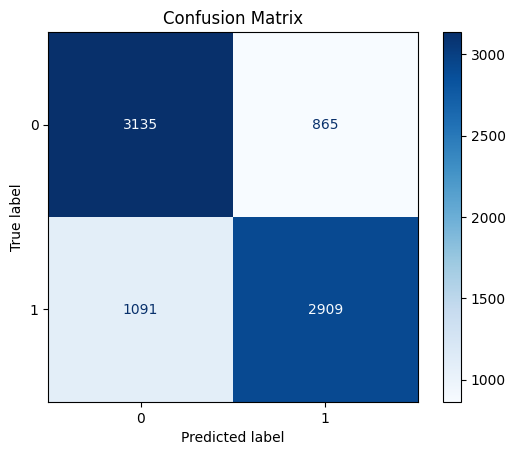

In [78]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [79]:
from sklearn.metrics import roc_curve, auc

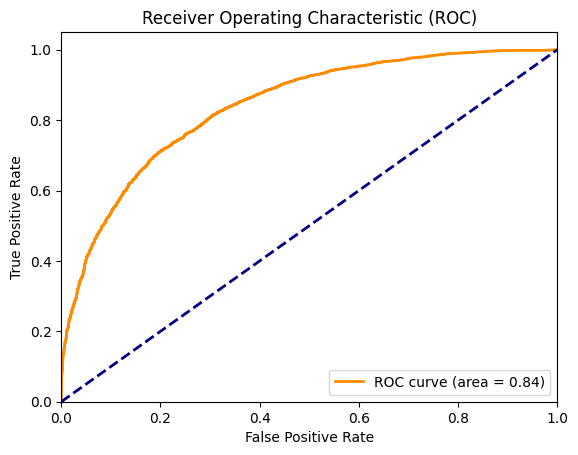

In [81]:
pred_probs = predictions.predictions
# If you have multiple classes, you need to compute the ROC AUC for each class
# For binary classification, consider only one class (usually positive class)

# Assuming binary classification with class 1 as positive class
fpr, tpr, _ = roc_curve(true_labels, pred_probs[:, 1], pos_label=1)  # Adjust if your model outputs probabilities for each class
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Sentiment140 BERT

In [83]:
tokenizer = AutoTokenizer.from_pretrained("pig4431/Sentiment140_BERT_5E")
model = AutoModelForSequenceClassification.from_pretrained("pig4431/Sentiment140_BERT_5E",
                                                           num_labels=2, 
                                                           ignore_mismatched_sizes=True)

In [84]:
# Set parameters
MAX_LENGTH = 150

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./output/sen140bert-tuned-v1",
    report_to=None,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-5,
    weight_decay=0.01,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./sen140-logs",
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [85]:
train_encodings = tokenizer(x_train, truncation=True, padding="max_length", max_length=MAX_LENGTH)
valid_encodings = tokenizer(x_valid, truncation=True, padding="max_length", max_length=MAX_LENGTH)
test_encodings = tokenizer(x_test, truncation=True, padding="max_length", max_length=MAX_LENGTH)

In [86]:
train_dataset = Dataset(train_encodings, y_train)
valid_dataset = Dataset(valid_encodings, y_valid)
test_dataset = Dataset(test_encodings, y_test)

In [87]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
)

In [89]:
from unittest import mock
from unittest.mock import Mock
class Dummy:
    def __enter__(self):
        return Mock()

    def __exit__(self, *args):
        pass

with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
500,No log,0.524489
1000,No log,0.512530
1500,No log,0.513698
2000,0.532000,0.538501
2500,0.532000,0.523573
3000,0.532000,0.528741
3500,0.432300,0.594933
4000,0.432300,0.622785
4500,0.432300,0.609765
5000,0.339000,0.725280


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

In [90]:
trainer.evaluate()

predicted = trainer.predict(test_dataset)
predictions = predicted.predictions

predicted_classes = predictions.argmax(-1)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted_classes, average=None)
accuracy = accuracy_score(y_test, predicted_classes)

for i in range(len(set(y_train))):
    print(f"Class {i}: Precision: {precision[i]}, Recall: {recall[i]}, F1: {f1[i]}")

print(f"Overall accuracy: {accuracy}")

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Class 0: Precision: 0.7637362637362637, Recall: 0.72975, F1: 0.7463564305804141
Class 1: Precision: 0.7412637625658209, Recall: 0.77425, F1: 0.7573978967962827
Overall accuracy: 0.752


In [91]:
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)  # Adjust if your model outputs probabilities
true_labels = predictions.label_ids

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


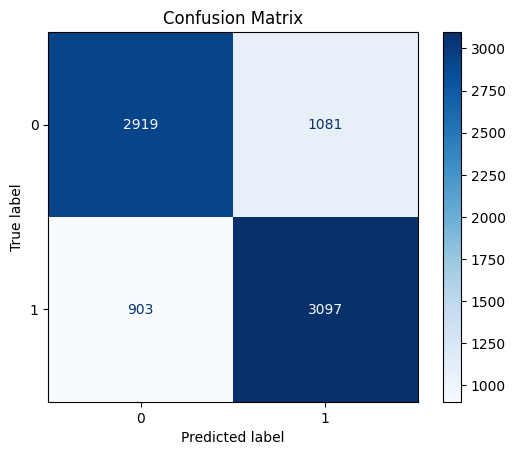

In [92]:
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

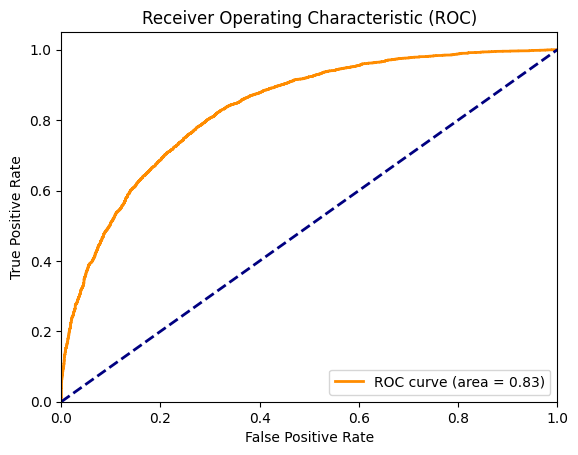

In [93]:
pred_probs = predictions.predictions
# If you have multiple classes, you need to compute the ROC AUC for each class
# For binary classification, consider only one class (usually positive class)

# Assuming binary classification with class 1 as positive class
fpr, tpr, _ = roc_curve(true_labels, pred_probs[:, 1], pos_label=1)  # Adjust if your model outputs probabilities for each class
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# https://huggingface.co/austinmw/distilbert-base-uncased-finetuned-tweets-sentiment
# https://huggingface.co/distilbert/distilbert-base-uncased
# https://huggingface.co/distilbert/distilgpt2